In [1]:
%matplotlib inline

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import sys
import time
import glob
from itertools import chain
from glob import glob
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import re
from skimage import io, exposure, img_as_float

matplotlib.rcParams['font.size'] = 8

##Import any other packages you may need here

EDA is open-ended, and it is up to you to decide how to look at different ways to slice and dice your data. A good starting point is to look at the requirements for the FDA documentation in the final part of this project to guide (some) of the analyses you do. 

This EDA should also help to inform you of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. 

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 

Perform the following EDA:
* The patient demographic data such as gender, age, patient position,etc. (as it is available)
* The x-ray views taken (i.e. view position)
* The number of cases including: 
    * number of pneumonia cases,
    * number of non-pneumonia cases
* The distribution of other diseases that are comorbid with pneumonia
* Number of disease per patient 
* Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

Note: use full NIH data to perform the first a few EDA items and use `sample_labels.csv` for the pixel-level assassements. 

Also, **describe your findings and how will you set up the model training based on the findings.**

In [2]:
## Below is some helper code to read data for you.
## Load NIH data
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_xray_df.sample(3)

## Load 'sample_labels.csv' data for pixel level assessments
sample_df = pd.read_csv('sample_labels.csv')
sample_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
607,00003122_017.png,No Finding,17,3122,057Y,M,PA,2992,2991,0.143,0.143
881,00004656_002.png,Atelectasis,2,4656,045Y,M,AP,2500,2048,0.171,0.171
2146,00011065_007.png,No Finding,7,11065,066Y,M,PA,2992,2991,0.143,0.143


In [3]:
# Rolling the Labels columns

all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
all_xray_df.sample(3)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
72981,00017981_010.png,Infiltration,10,17981,43,F,AP,2500,2048,0.168,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
59939,00014797_000.png,No Finding,0,14797,39,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
516,00000121_002.png,No Finding,2,121,53,M,PA,2886,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [4]:
# Number of samples with Pneumonia

no_images_pneumonia = len(all_xray_df[all_xray_df.Pneumonia==1])
print("\nTotal number of Images with Pneumonia: {}\n".format(no_images_pneumonia))


Total number of Images with Pneumonia: 1431



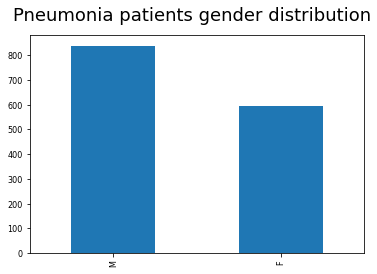

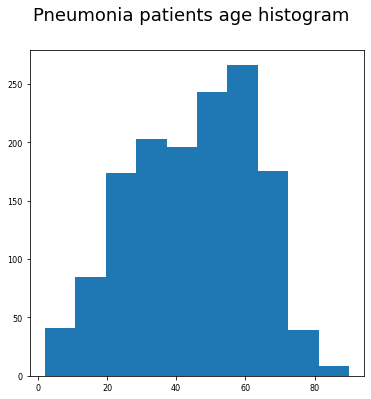

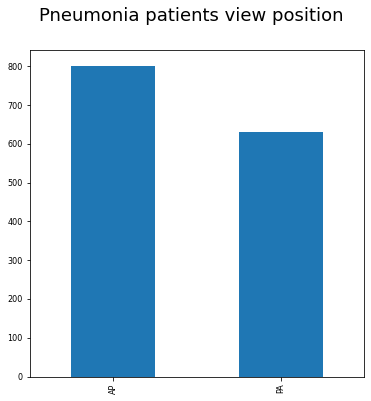

In [5]:
# Exploring patient gender

plt.figure().suptitle('Pneumonia patients gender distribution', fontsize=18)
all_xray_df[all_xray_df.Pneumonia==1]['Patient Gender'].value_counts().plot(kind='bar')

print("\n\n")
# Exploring patient age. Removing the outlier sample point
plt.figure(figsize=(6,6)).suptitle('Pneumonia patients age histogram', fontsize=18)
plt.hist(all_xray_df[all_xray_df.Pneumonia==1]['Patient Age'][all_xray_df['Patient Age'] < 412])
    
print("\n\n")
# Exploring patient position
plt.figure(figsize=(6,6)).suptitle('Pneumonia patients view position', fontsize=18)
all_xray_df[all_xray_df.Pneumonia==1]['View Position'].value_counts().plot(kind='bar')

The sample set shows some skewing towards the male population.

([<matplotlib.axis.XTick at 0x7f1e195d2190>,
 [Text(0, 0, '15K'),
  Text(0, 0, '10K'),
  Text(0, 0, '5K'),
  Text(0, 0, '0'),
  Text(0, 0, '5K'),
  Text(0, 0, '10K')])

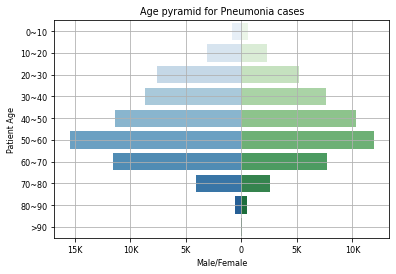

In [6]:
# Exploring age across genders

# Adding age range columns
labels = ['0~10', '10~20', '20~30', '30~40', '40~50', '50~60',
         '60~70', '70~80', '80~90', '>90']
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, np.inf]

age_groups = pd.cut(all_xray_df['Patient Age'], 
                    bins=bins, labels=labels, 
                    right=False)

age_gender_df = pd.crosstab(age_groups, 
                            columns = all_xray_df['Patient Gender'])

age_gender_df['M'] = age_gender_df['M']*-1

ax1_m = sns.barplot(x='M', y=age_gender_df.index, 
                    data=age_gender_df, 
                    order=age_gender_df.index, 
                    palette='Blues')
ax2_f = sns.barplot(x='F', y=age_gender_df.index, 
                    data=age_gender_df, 
                    order=age_gender_df.index, 
                    palette='Greens')
plt.title("Age pyramid for Pneumonia cases")
plt.xlabel("Male/Female")
plt.grid()
plt.xticks(ticks=[-15000, -10000, -5000, 0, 5000, 10000], 
           labels=['15K', '10K', '5K', '0', '5K', '10K'])
    


In [7]:
# Exploring views taken
df_length = len(all_xray_df)

total_ap = all_xray_df['View Position'][all_xray_df['View Position'] == 'AP']\
                                      .shape[0]
total_pa = all_xray_df['View Position'][all_xray_df['View Position'] == 'PA']\
                                      .shape[0]
print("Total number of views taken: {}\n".format(df_length))
print("Total number of AP views taken: {}\n".format(total_ap))
print("Total number of PA views taken: {}\n".format(total_pa))
print("% of AP views: {0}, {1:.0%}\n".format(total_ap, total_ap/df_length))
print("% of PA views: {0}, {1:.0%}\n".format(total_pa, total_pa/df_length))


Total number of views taken: 112120

Total number of AP views taken: 44810

Total number of PA views taken: 67310

% of AP views: 44810, 40%

% of PA views: 67310, 60%



In [8]:
# Exploring Pneumonia cases

total_pneumonia = all_xray_df[all_xray_df['Pneumonia']==1]['Pneumonia'].shape[0]
total_not_pneumonia = all_xray_df[all_xray_df['Pneumonia']!=1]['Pneumonia'].shape[0]

print("Total number of Pneumonia cases: {}\n".format(total_pneumonia))
print("Total number of non-Pneumonia cases: {}\n".format(total_not_pneumonia))

Total number of Pneumonia cases: 1431

Total number of non-Pneumonia cases: 110689



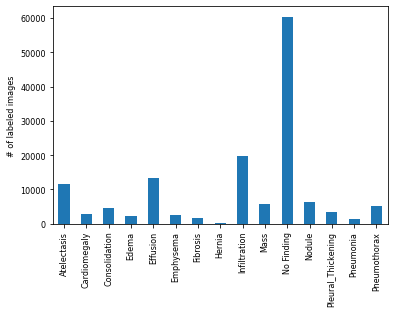

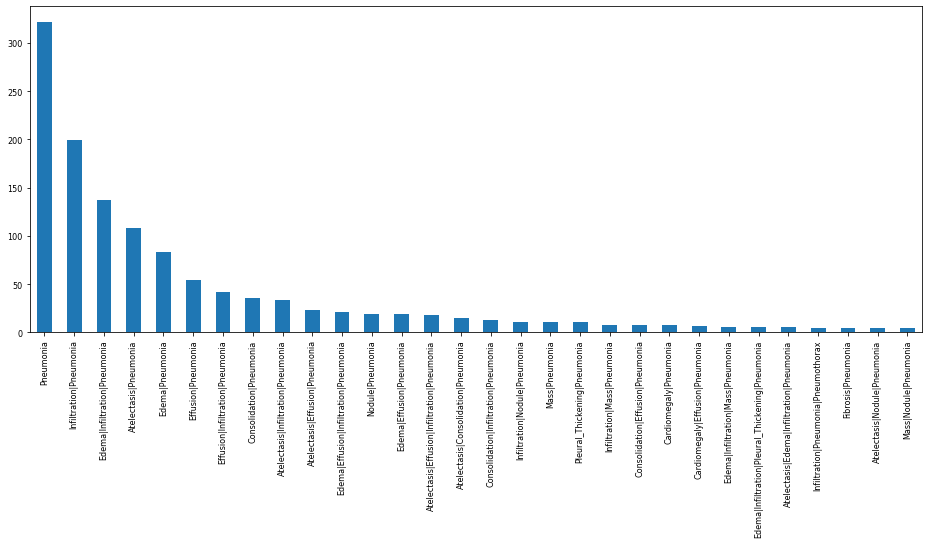

In [9]:
# Investigating diseases distribution and comorbidity

plt.figure()
ax = all_xray_df[all_labels].sum().plot(kind='bar').set(ylabel='# of labeled images')

# Top 30 comorbids with Pneumonia 
plt.figure(figsize=(16,6))
all_xray_df[all_xray_df.Pneumonia==1]['Finding Labels'].value_counts()[0:30].plot(kind='bar')

[Text(0, 0.5, 'Frequency of diseases count'),
 Text(0.5, 0, 'Diseases count per pneumonia patient')]

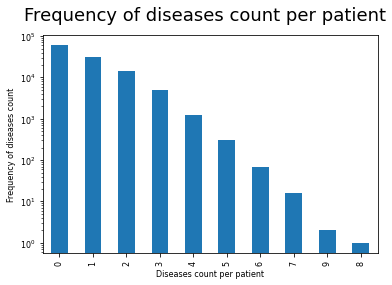

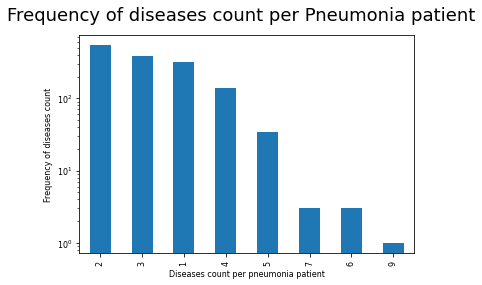

In [10]:
# Investigating number of diseases per patient

all_xray_df['No_diseases'] = all_xray_df['Finding Labels'].map(lambda x: len(re.findall(r'((?=[^No Finding])\w+)', x)))

all_xray_df[['Image Index',
 'Finding Labels','No_diseases']]

plt.figure().suptitle('Frequency of diseases count per patient', fontsize=18)
plt.yscale('log',basey=10) 
all_xray_df['No_diseases'].value_counts().plot(kind='bar')\
                            .set(ylabel='Frequency of diseases count', xlabel='Diseases count per patient')

plt.figure().suptitle('Frequency of diseases count per Pneumonia patient', fontsize=18)
plt.yscale('log',basey=10) 
all_xray_df[all_xray_df.Pneumonia==1]['No_diseases'].value_counts().plot(kind='bar')\
                            .set(ylabel='Frequency of diseases count', xlabel='Diseases count per pneumonia patient')

The sample set exhibits Pneumonia being comorbid with a second disease in most of the samples.

In [11]:
# Studying the sample dataset for pixel-level assessment

sample_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
242,00001301_013.png,Infiltration,13,1301,057Y,F,AP,2500,2048,0.168,0.168
706,00003678_001.png,Pleural_Thickening,1,3678,047Y,M,PA,2500,2048,0.171,0.171
2659,00013392_001.png,Effusion,1,13392,044Y,F,PA,2992,2991,0.143,0.143


In [12]:
# Rolling the Finding Labels column
all_labels = np.unique(list(chain(*sample_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        sample_df[c_label] = sample_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
sample_df.sample(3)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
3844,00018921_024.png,Effusion|Pneumothorax,24,18921,043Y,F,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2117,00010870_000.png,Effusion,0,10870,071Y,M,PA,2830,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3692,00018120_001.png,Atelectasis|Hernia,1,18120,067Y,M,PA,2992,2991,0.143,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
# Building the image path for the sample_df

all_images_paths = {os.path.basename(x): x for x in
                    glob(os.path.join('/data','images*','*','*.png'))}

print('Scan found: ', len(all_images_paths), ', Total headers: ', sample_df.shape[0])
sample_df['path'] = sample_df['Image Index'].map(all_images_paths.get)
sample_df.head(3)

Scan found:  112120 , Total headers:  5606


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,path
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,/data/images_001/images/00000013_005.png
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,/data/images_001/images/00000013_026.png
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,/data/images_001/images/00000017_001.png


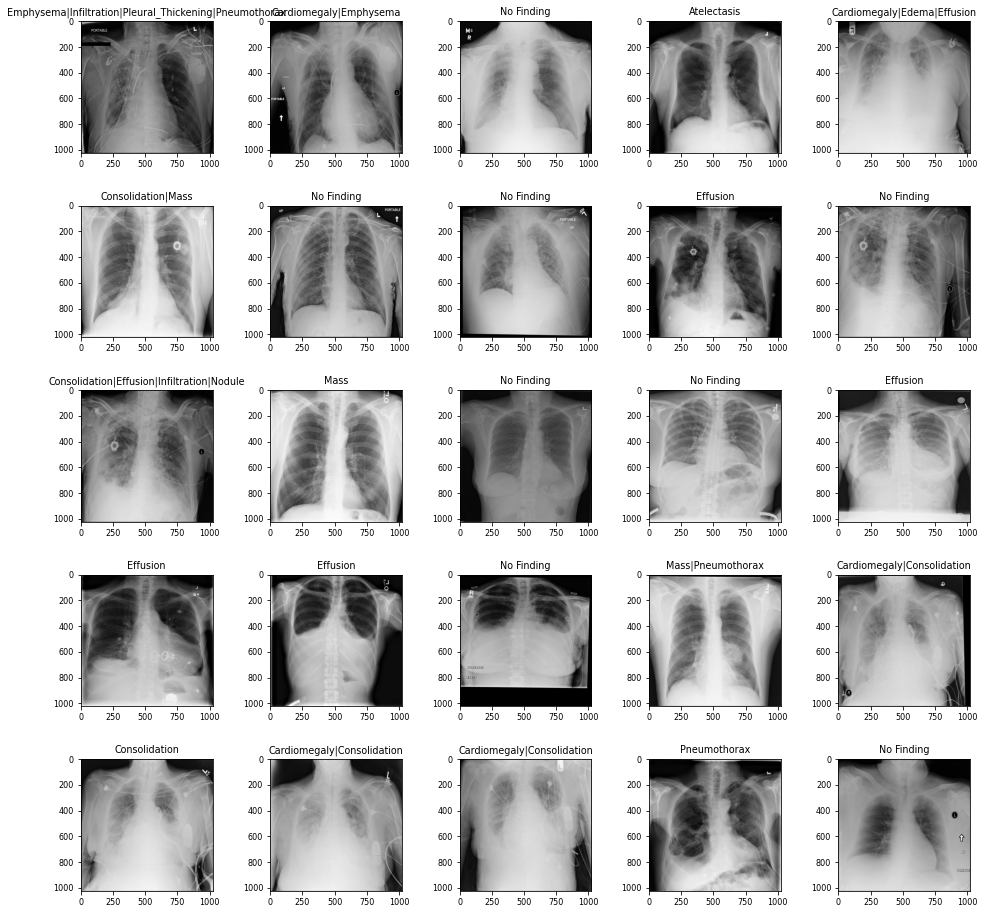

In [14]:
# A general first random look at the x-rays
fig, m_axis = plt.subplots(5, 5, figsize= (16, 16), constrained_layout=False)
fig.subplots_adjust(hspace=0.4, wspace=0.4)
m_axis = m_axis.flatten()
imgs = sample_df['path']
ind=0

for img, ax in zip(imgs, m_axis):
    img = io.imread(img)
    ax.imshow(img,cmap='gray')
    ax.set_title(sample_df.iloc[ind]['Finding Labels'])
    ind=ind+1
    

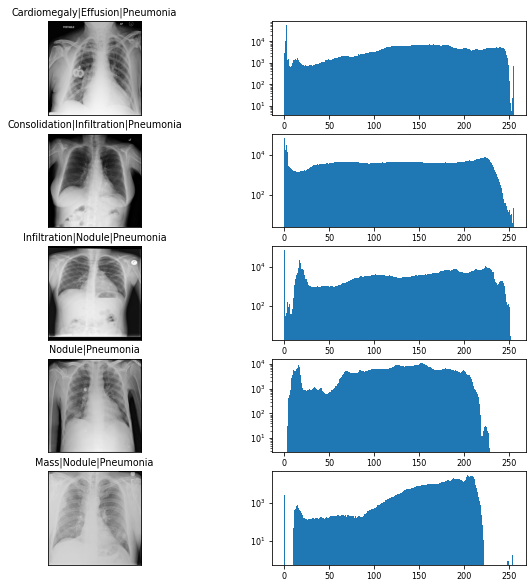

In [15]:
## Looking at different co-morbid diseases histograms (logarithmic scale)

img, m_axis = plt.subplots(5, 2, figsize= (10, 10), constrained_layout=False)
fig.subplots_adjust(hspace=0.4, wspace=0.4) 
bins = np.arange(-0.5, 255+1, 1)
imgs = sample_df[sample_df['Pneumonia'] == 1]['path']
ind=0
for img, ax in zip(imgs, m_axis):
    img = io.imread(img)
    ax[0].imshow(img, cmap='gray')
    ax[0].set_title(sample_df[sample_df['Pneumonia'] == 1].iloc[ind]['Finding Labels'])
    ax[0].get_xaxis().set_visible(False)
    ax[0].get_yaxis().set_visible(False)
    ax[1].hist(img.flatten(), bins = bins)
    ax[1].set_yscale("log")
    ind=ind+1

Pneumonia expresses some boosts in the frequency of the low intensity pixels in the range from 0 to 20

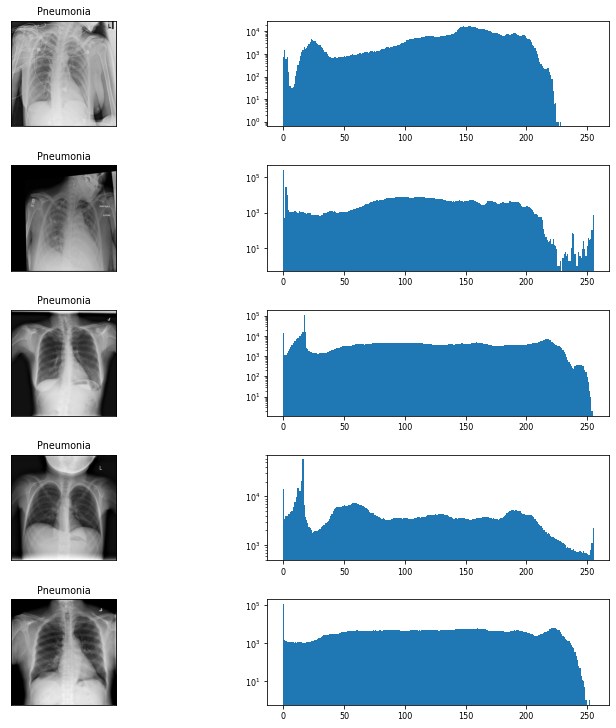

In [16]:
## Looking at Pneumonia-only histograms (logarithmic scale)

img, m_axis = plt.subplots(5, 2, figsize= (10, 10), constrained_layout=True)
bins = np.arange(-0.5, 255+1, 1)
imgs = sample_df[sample_df['Finding Labels'] == 'Pneumonia']['path']
ind=0
for img, ax in zip(imgs, m_axis):
    img = io.imread(img)
    ax[0].imshow(img, cmap='gray')
    ax[0].set_title(sample_df[sample_df['Finding Labels'] == 'Pneumonia'].iloc[ind]['Finding Labels'])
    ax[0].get_xaxis().set_visible(False)
    ax[0].get_yaxis().set_visible(False)
    ax[1].hist(img.flatten(), bins = bins)
    ax[1].set_yscale("log")
    ind=ind+1

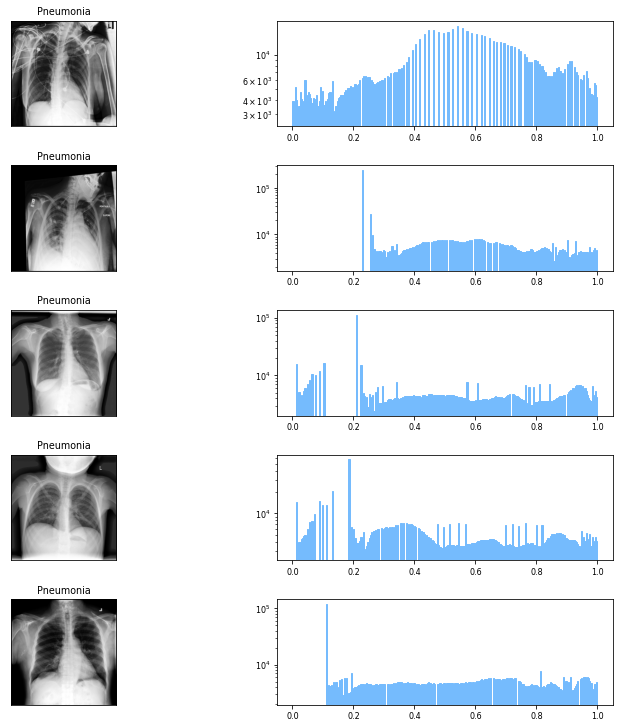

In [17]:
## Inspecting Pneumonia-only histograms (logarithmic scale) with image equalization through a 
## monotonic non-linear mapping

img, m_axis = plt.subplots(5, 2, figsize= (10, 10), constrained_layout=True)
bins = np.arange(-0.5, 255+1, 1)
imgs = sample_df[sample_df['Finding Labels'] == 'Pneumonia']['path']
ind=0
for img, ax in zip(imgs, m_axis):
    img = io.imread(img)
    eq_img = exposure.equalize_hist(img)
    ax[0].imshow(eq_img, cmap='gray')
    ax[0].set_title(sample_df[sample_df['Finding Labels'] == 'Pneumonia'].iloc[ind]['Finding Labels'])
    ax[0].get_xaxis().set_visible(False)
    ax[0].get_yaxis().set_visible(False)
    ax[1].hist(eq_img.ravel(), bins=256, range=(0.0, 1.0), fc='xkcd:sky blue', ec='xkcd:sky blue')
    ax[1].set_yscale("log")
    ind=ind+1

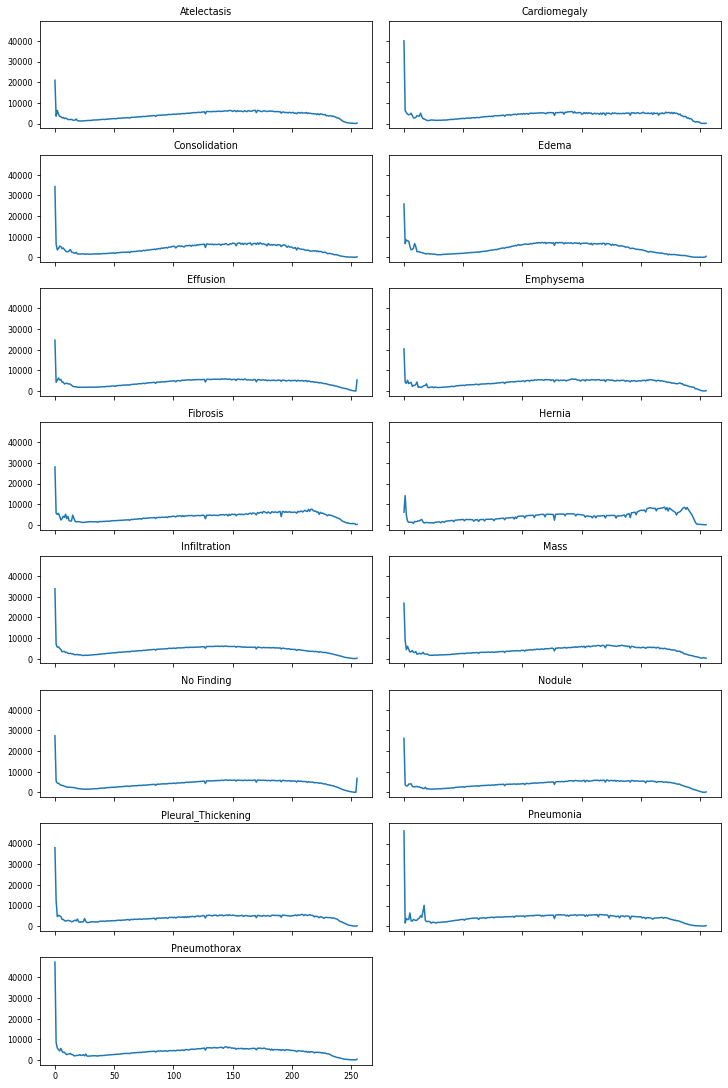

In [18]:
## Investigating the normalized combined histograms for different diseases

figure, m_axis = plt.subplots(int((len(all_labels)+1)/2), 2, 
                              figsize= (10, 15),
                              sharex=True,
                              sharey=True,
                              constrained_layout=True)
if len(all_labels)%2!=0:
    figure.delaxes(m_axis[int((len(all_labels)+1)/2)-1][1])
    
bins = np.arange(-0.5, 255+1, 1)
idx = img_ind = axis_ind = fig_ind = 0

# Building the histogram data dictionary
categories_histograms = {}
for idx, c_label in enumerate(all_labels):
    imgs = sample_df[sample_df['Finding Labels'] == c_label]['path']
    imgs_count=len(imgs)
    hist_accumulator = np.zeros_like(exposure.histogram(img_as_float(
                                                io.imread(imgs.iloc[0])), 
                                                nbins=256)[0])
    
    for img in imgs:
        img_io = io.imread(img)
        img_hist = exposure.histogram(img_as_float(img_io), nbins=256)
        hist_accumulator = np.add(hist_accumulator, img_hist[0])
        img_ind = img_ind+1
        print("\r{}: Image {} of {}{:>20}".format(c_label, img_ind, imgs_count,'\r'), 
              end='', flush=True)
    
    # Normalization of compund histogram
    hist_norm = hist_accumulator / imgs_count
    # Building the histogram dictionary for the categories
    categories_histograms[c_label] = hist_norm
    
    img_ind, axis_ind = 0, idx%2
    if idx > 1:
        fig_ind = fig_ind+(idx+1)%2
    m_axis[fig_ind, axis_ind].plot(hist_norm)
    m_axis[fig_ind, axis_ind].set_title(c_label)    
        

As  above the Pneumonia